---
### *The Tenth Computational Neuroscience Winter School*
# Tutorial I: Neuronal Dynamics - Point Neuron Model
---
__Date:__ Jan. 13, 2021

__Content Creator:__ Songting Li, Kai Chen


## Using tutorial notebook

Please download the latest version of [Jupyter Notebook](https://jupyter.org) if you want to try run all tutorials on your own laptop.

**Gray cells are executable code cells. To execute, click on a cell and press `Shift + Enter`.**

**To modify text in a cell, click on the cell and type.**

Note that most function stubs are suggestions. Feel free to code up whatever solves the task.

If something behaves weird, it always is worth a try to restart the kernel.

---
# Tutorial Objectives
In this notebook, we will learn how to use python to solve differential equations that describe the dynamics of neurons. We will cover single-compartment neurons and simplest spatial neuron models (ball and stick) in next notebook.

In the course of this notebook, we will learn how to simulate the single point neuron model, including LIF and reduced HH neuron (Fitzhugh-Nagumo model):
1. Initialize model and variable state;
1. Record output, such as membrane potentials and spikes
1. Drive the neurons by external input

In doing so we will practice 

- To make use of modular programming
- To write testing functions to check and optimize code 

## Setup

In [1]:
# @title Import most modules and functions needed
import time
import numpy as np 
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# General coding remarks

In your very own interest (but also the interest of everyone who ever has to work with your code) it really helps, if you always:

- structure your code clearly, such that you can quickly grasp where loops begin and end, etc. 

- choose sensible names for your functions, e.g. call a routine that stores spikes `store_spikes`, one that plots membrane potentials `plot_pots`, or something similar. 

- choose sensible names for your variables, e.g. call a variable that encodes the membrane potential `V` or `Vm`, a space variable `x`, a time variable `t`, and so on. You get the gist :-)

- add comments about what individual lines/sections of code do, for (stupid) example: 

```python
>>> v=v+c # this adds the constant c to v
```

- add doc strings to your functions: that is the text in between ''' in the beginning of each function definition (see examples below). Doc strings should describe what the function does and what the input variables and parameters are. 

```python
>>> def func():
>>>     '''
>>>     This is a function. It does things.
>>>     '''
>>>     
>>> # You can print this info by typing 'print(func.__doc__)'     
>>> print(func.__doc__)    
This is a function. It does things.
    
```

Also: **SAVE REGULARLY!!!** You don't want to lose the most brilliant few lines of code you ever produced, nor more regular tedious work to [insert random thing that WILL happen and kill your running program]

Though `Jupyter Notebook` helps by regularly creating checkpoints, you'd better mannully save your modifications.

### Modular Programming

It is extremely helpful to structure your code into seperate independent functions or modules. 

For example, instead of having one huge simulation function which initializes all dynamical variables, updates the dynamical states, checks for state transitions (e.g. threshold crossings), and writes output to file, you should split it into basic functions that do one thing, and one thing only [UNIX philosophy:)].

This has several advantages:

- it increases readability of complex code;
- each function can be more easily tested and maintained;
- each function can be easily changed or replaced without affecting the behavior of other functions;
- each function can be easily reused, in the best case scenario saving you work at a later point in time;


## Numpy Broadcasting

If you want to multiply each element of `a` by `2.0`, you may implement a loop operation as follows.
```python
>>> import numpy as np
>>> a = np.array([1.0,2.0,3.0])
>>> for i in range(len(a)):
>>>     a[i] = a[i] * 2.0
>>> print(a)
[2., 4., 6.]
```

Numpy's broadcasting rule allows you to implement element-wise operations by directly interact numpy.array with scalars, shown as the following examples.

```python
>>> import numpy as np
>>> a = np.array([1.0,2.0,3.0])
>>> a = a * 2.0
>>> print(a)
[2., 4., 6.]
```
![img](https://numpy.org/devdocs/_images/theory.broadcast_1.gif)
As the sketch and figure above, broadcasting provides a means of vectorizing array operatings so that looping occurs in C instead of Python. We may use `time.time()` to verify it.



In [2]:
import numpy as np
import time
# Python Looping
a = np.arange(1000000, dtype=float)
t0 = time.time()
for i in range(len(a)):
    a[i] *= 2.0
print(f'Python looping takes {time.time()-t0:.3f}s')
print('Last 5 elements in a: ', a[-5:])

# Numpy broadcasting
a = np.arange(1000000, dtype=float)
t0 = time.time()
a = a * 2.0
print(f'Python looping takes {time.time()-t0:.3f}s')
print('Last 5 elements in a: ', a[-5:])

Python looping takes 0.363s
Last 5 elements in a:  [1999990. 1999992. 1999994. 1999996. 1999998.]
Python looping takes 0.004s
Last 5 elements in a:  [1999990. 1999992. 1999994. 1999996. 1999998.]


**More broadcasting, less loops!**

### Testing functions

It is critical to test each function before putting all of them together. Writing a proper test of a function will give you confidence that a function is working properly. The test should be simple enough, yet still contain  typical situation(s) to be met when all functions are put together.

E.g. if you have a function that detects a threshold crossing and resets the dynamical state as a consequence, you want to make sure that it correctly identifies the crossing and correctly resets to the desired value. To do so, you could give an increasing time series that contains the threshold value as an input and measure the output for expected behavior.

# Point neuron models

## Fitzhugh-Nagumo model

Most of you will in one way or another have encountered the famous Hodgkin-Huxley (HH) model for the dynamics of neuronal membranes. It is a powerful biophysical model to explain many aspects of membrane excitability, such as action potential generation and the role of ion channels, in particular sodium and potassium, in it. 

The Fitzhugh-Nagumo model is a model that reduces the complexity of the HH model to two dimensions, while still capturing the key aspects of the dynamics. Most of all, the reduction makes it amenable to dynamical system analysis techniques.

The membrane potential equation for the Fitzhugh-Nagumo model is given by

\begin{eqnarray}
\frac{d}{dt} v(t) &=& v - \frac{v^3}{3} - w + I\quad (1.1)\\
\frac{d}{dt}w(t) &=& \epsilon\,(b_0+b_1 v - w)\quad (1.2)
%\tau \frac{d}{dt}w(t) &=& v + a -bw
\end{eqnarray}

$I$ is a driving current, $v(t)$ is a fast variable (membrane potential), $w(t)$ is a slow recovery variable.





## Step 1: Initialization and Output monitor functions 

### Example: membrane potential recorder

To write membrane potential recording and plotting functions we want three different functions:

- `init_rec_pot()`: should initialize the object which you will store potentials in
- `store_pot()`: should record all potential values at a given time point
- `plot_pot()`: should plot the membrane potential as a function of time  

We can print the time taken by the whole session by using `time.time()`. This is helpful for optimizing code.

In [3]:
# if you want to initialize all traces to already have the full length=number of sample points=n_timesteps
def init_rec_pot(n_neuron,n_timesteps):
    '''
    Initializes dictionary of potential trace arrays. 
    
    Args:
    n_neuron    : number of neurons for which you want to store the potential 
    n_timesteps : number of time steps 
    
    Returns:
    rec_pot     : dictionary object rec_pot
    '''
    rec_pot = np.zeros((n_neuron, n_timesteps))     # initialize a 2-D array with all entries=0 
                                                    # i-th row represents the trace of each neuron i
                                                    # j-th column represents the potential of all neurons
                                                    #   at j-th time point;
    return rec_pot

        
def store_pot(rec_pot,V,it):
    '''
    Stores potentials in dictionary rec_pot 
    
    Args:
    rec_pot: dictionary of potential traces
    V      : vector of current potential values
    it     : current time step
    
    Returns:
    does not return anything, this functions just updates the storing object
    '''
    rec_pot[:, it] = V      # assign potential value V of all neurons at time it 
                            # to corresponding entries of rec_pot
    
def plot_pot(rec_pot, time=None):
    '''
    Plots potentials stored in dictionary rec_pot 
    
    Args:
    rec_pot: dictionary of potential traces
    time   : time ticks of x-axis
   
    Returns:
    does not return anything, this functions just plots the contents of rec_pot
    '''
    cnt   = 0               # counter, only needed for plotting in different colors; 
                            # for keys==range(n_neuron) can use i directly
        
    for trace in rec_pot:   # iterate through all rows of the rec_pot array
        # plot gray scale solid lines (-) with linewidth (lw) 2 
        if time is None:
            plt.plot(trace,'-',color='%s'%((1.+cnt)/(len(rec_pot)+1)),lw=2, label=str(cnt+1)) 
        else:
            plt.plot(time, trace,'-',color='%s'%((1.+cnt)/(len(rec_pot)+1)),lw=2, label=str(cnt+1)) 
        cnt+=1
    

We will now use some mock potential data to see if the three functions init_rec_pot(), store_pot() and plot_pot() do what they should.

Running time is 0.01602 s


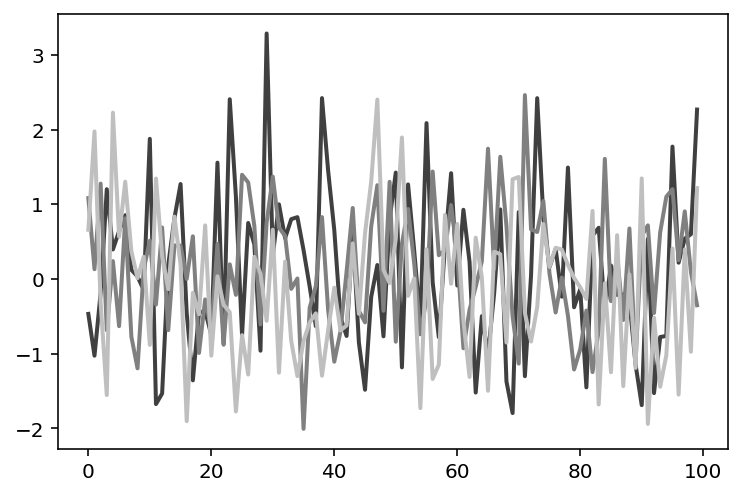

In [4]:
T, dt     = 10, 0.1                        # total time T [ms], time increment dt [ms]
n_neuron  = 3                              # number of neurons
ts        = np.arange(0,T,dt)              # time vector
rec_pot   = init_rec_pot(n_neuron,len(ts)) # create rec_pot object
starttime = time.time()                    # you can clock how long your code needs, useful during optimization               

#print rec_pot                             # how does it look?

### run "pseudo-dynamics" 
# first, create an update function for the potential dynamics (here, simply creating Gaussian random numbers)
def update(n_neuron):
    return np.random.randn(n_neuron)

for it in range(len(ts)):
    vs = update(n_neuron)                  # for each time step update potential values
    store_pot(rec_pot,vs,it)               # hand to store_pot function
    
#print rec_pot                             # how does it look?

# plot potential traces: should give n_neuron random traces in varying gray tones
plot_pot(rec_pot)
endtime = time.time()
print(f'Running time is {endtime-starttime:0.5f} s')

## Step 2: Numerical ODE Solver
---

### Euler integration
Consider a differential equation of the type

$$
\tau \frac{d}{dt} x(t) = -x(t) +I\,,\quad(i)
$$

where $I$ is some constant input that drives the dynamics of the variable $x(t)$, and $\tau$ is some time constant that tunes how fast $x$ reacts to the input $I$.

For this type of equation it is straightforward to write down the solution, i.e.,

$$
x(t) = I\,(1-e^{-t/\tau}) + x_0\,e^{-t/\tau}\,,\quad (ii)
$$

where $x_0=x(t_0)$ is the initial condition. Indeed, if we compute the temporal derivative of $(ii)$ we get

\begin{eqnarray}
\frac{d}{dt} x(t) \quad &=& \quad \frac{d}{dt} \big(I\,(1-e^{-t/\tau}) + x_0\,e^{-t/\tau}\big) \quad =\quad  \frac{1}{\tau} \left(I\,e^{-t/\tau} -x_0 \,e^{-t/\tau}\right)  \\
\Leftrightarrow\quad \tau \frac{d}{dt} x(t) \quad &=& \quad I\,e^{-t/\tau} - x_0 \,e^{-t/\tau} + (I-I) \,\, \,\quad =\quad  -x(t) +I\,.
\end{eqnarray}

Not every differential equation is so easy to solve, so it is useful to know how to numerically compute such problems.

The most straight-forward (though not necessarily always best or optimal) way to do that is by *Euler integration*.

### Discretization

We start from $(i)$ by substituting 

$$dt \rightarrow  \Delta t= t_{i+1}-t_i, \quad dx \rightarrow \Delta x = x(t_{i+1})-x(t_i)=: x_{i+1}-x_i$$ 

The time increment $\Delta t$ is usually a fixed number that should be considerably smaller than the smallest other time constant in the system in order to obtain a good approximation (here $\tau$). You also don't want it to be unnecessarily small, because simulation time will increase the smaller $\Delta t$. If you are unsure, whether you chose a good $\Delta t$, try varying it and observe how much the result varies. 


### Initialize

Whenever we want to solve differential equations, we have to define an initial condition. So we will have to have an initialization step for $x$:

$$x(0)=x_0$$ 

### Update

The discretized version of $(i)$ is given by

\begin{aligned}
\tau\, \frac{\Delta x}{\Delta t} \quad &= \quad -x_i + I\\
\Leftrightarrow\quad  \Delta x \quad = \quad x_{i+1} - x_i  \quad &= \quad \Delta t \left[ \frac{1}{\tau}\,\big( -x_i +I \big)\right]\\
\Leftrightarrow\quad\quad \quad\quad\quad\quad\quad x_{i+1}\quad &= \quad x_i + \Delta t \, \left[ \frac{1}{\tau}\,\big( -x_i +I \big)\right]
\end{aligned}

The Euler integration update step always has the same form, i.e., 

$$
x_{i+1} = x_i + \Delta t f(x) \quad (1)
$$

When we write code, we want to save as much work as possible, not only by letting the computer do all the tedious calculations, but also by reducing the amount of typing work in the future. So we should design our code such that it is flexible and reusable. These are benefits that *modularization* gives us.

We can write a function called euler_step($x$,f,$\Delta t$) that just does Eqn.(1), regardless of what f does.

Then, for what is specific to the dynamics at hand, we will have a function called, here e.g., f = f_x($x,  
I,\tau$) that computes $\left[ \frac{1}{\tau}\,\big( -x_i +I \big)\right]$.

This way, whenever we want to solve a dynamics with Euler integration again, we can just use euler_step() again and simply exchange $f$.

So let's do that in python code!

In [5]:
## function for Euler integration step
def euler_step(x,f,dt):
    '''
    Executes Euler integration step
    
    Expects:
    x     : state variable
    f     : increment of x
    dt    : increment of t
    
    Returns:
    updated state x
    ''' 
    return x + dt*f


## specific functional increment
def f_x(x,I,tau):
    '''
    Computes increment dx/dt of state variable for Eqn.(i)
    
    Expects:
    I    : constant drive
    tau  : time constant
    
    Returns:
    state variable increment
    '''
    return (I-x)/tau

We have all necessary ingredients to run the full dynamics Eqn.(i), we only have to put it together into one function.

In [6]:
def run_dynamics(x0,I,tau,T,dt):
    '''
    Runs the low-pass filter dynamics Eqn.(i)
    
    Expects:
    x0   : initial condition
    I    : drive
    tau  : time constant
    T    : total run time
    dt   : time increment
    
    Returns: 
    rec_x : dicitionary of x trajectory
    '''
    rec_x = init_rec_pot(1,int(T/dt)) # initialize x-recorder
    x     = x0                        # initialize x
    for it in range(int(T/dt)):
        f = f_x(x,I,tau)              # increment of x
        x = euler_step(x,f,dt)        # update of x
        store_pot(rec_x,x,it)         # store
    return rec_x    
        

The code below plots the result of our Euler integration in comparison to the analytical solution. Play with dt to see what effect it has. 

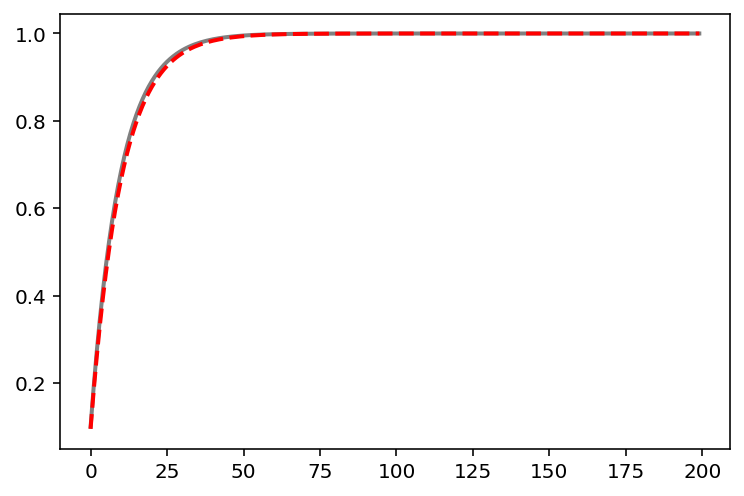

In [7]:
## define params
x0   = 0.
I    = 1.
tau  = 1.
T,dt = 20.,0.1
## run dynamics
rx   = run_dynamics(x0,I,tau,T,dt)
ts   = np.arange(0,T,dt)
## plot the trace
plot_pot(rx)

## to check if solved correctly, add analytical solution Eqn.(ii)
def x_sol(t,x0,I,tau):
    return I*(1-np.exp(-t/tau)) + x0*np.exp(-t/tau)
## plot analytical trace
plt.plot(x_sol(ts+dt,x0,I,tau),'r--')  

### Now that we successfully set up devices to record and plot traces, and learned how to solve differential equations numerically, let's cook up our Fitzhugh Nagumo models.

## Euler integration for the Fitzhugh-Nagumo model
---

---

In order to solve these coupled equations numerically, we again interpret the differential dynamics in discrete time:

$$dt \rightarrow \Delta t= t_{i+1}-t_i, \quad dv \rightarrow \Delta v = v_{i+1}-v_i, \quad dw \rightarrow \Delta w =w_{i+1}- w_i$$ 

### Initialize

We will need an initialization step for $v,w$:

$$v(0)=v_0, \quad w(0)=w_0$$ 


### Update 

The next step is to update the dynamics from $t_i$ to $t_{i+1}$. We will use Euler integration to do this.

Take good care of the fact that Eqns.(1.1) and (1.2) are coupled. If we want to update one first, the second would already receive updated information, so in order to maintain causality, use some auxiliary names in the update

$$
hv = v_{i+1}\\
hw = w_{i+1}
$$

The discretized dynamics thus becomes:

\begin{eqnarray}
\Delta v = v_{i+1}-v_i &=& \Delta t \left (v_i - \frac{v^3_i}{3} - w_i + I(t_i) \right)\\
\\
\Leftrightarrow  v_{i+1}=:hv &=& v_i \,+ \,\Delta t \left (v_i - \frac{v^3_i}{3} - w_i + I(t_i) \right)\quad (2.1)\\
\\ \\
\Delta w = w_{i+1}-w_i &=& \Delta t\, \epsilon \, \big( b_0 + b_1 v_i -w_i\big)\\ \\
\Leftrightarrow w_{i+1}=: hw &=& w_i+\Delta t\, \epsilon \, \big( b_0 + b_1 v_i -w_i\big) \quad \quad (2.2)
\end{eqnarray}


We thus arrive at 

\begin{eqnarray}
hv &=& v \,+ \,\Delta t \left (v- \frac{v^3}{3} - w + I(t_i) \right)\quad (3.1)\\
hw &=& w \,+\,\Delta t\, \epsilon \, \big( b_0 + b_1 v -w\big) \quad (3.2)
\end{eqnarray}

Looking at Eqns.(3.1),(3.2), we recognize the identical Euler integration update structure in both cases ($x=\{v,w\}$):

$$
hx = x + \Delta t f(x) \quad (4)
$$

We can thus simply recycle our euler_step function from before and adapt the state variable increments on the RHS in Eqns.(3.1),(3.2): $f=$fitzhugh_nagumo($v,w,p$), where p contains all relevant parameters ($b_0,b_1,\epsilon$).

After the update is complete, we can set the new $v=hv, w=hw$ and reiterate. 


### To do:

Write
- init functions
- functions to compute v,w increments
- run-function, where you recycle euler_step for the update (remember to update both with the information of the current time step, see $hv,hw$ above)

Then, store and plot the resulting traces as we have done in the example on top! 

Try to come up with good tests to see if all functions have desired behavior!

Play with the individual parameters and see how the dynamics changes. 

In [8]:
def init_v(v0):
    
    '''
    Initializes v
    '''
    return v0
    
def init_w(w0):
    
    '''
    Initializes w
    '''
    return w0
        
    
def f_vw(v,w,eps,b0,b1,I):
    
    '''
    Computes v,w increments for Fitzhugh-Nagumo model
    
    Expects:
    v,w          : current values of v,w
    eps,b0,b1    : coupling parameters
    I            : drive
    
    Returns:
    fv,fw        : increments of v,w for Euler integration
    '''
    fv = v - v**3/3. - w + I 
    fw = eps*(b0 + b1*v - w) 
    return fv,fw
    
def run_fitzhugh_nagumo(v0,w0,eps,b0,b1,I,T,dt):
    
    '''
    Runs Fitzhugh-Nagumo dynamics
    
    Expects:
    
    v0, w0    : initial values
    eps,b0,b1 : coupling parameters
    I         : drive
    T         : total runtime
    dt        : time increment
    
    Returns:
    rec_v, rec_w : dictionary of v,w traces
    '''
    rec_v = init_rec_pot(1,int(T/dt))
    rec_w = init_rec_pot(1,int(T/dt))
    v     = init_v(v0)
    w     = init_v(w0)
    for it in range(int(T/dt)):
        fv,fw = f_vw(v,w,eps,b0,b1,I)
        v     = euler_step(v,fv,dt)
        w     = euler_step(w,fw,dt)
        store_pot(rec_v,[v],it)
        store_pot(rec_w,[w],it)
    return rec_v,rec_w   


Text(0, 0.5, '$v(t)$')

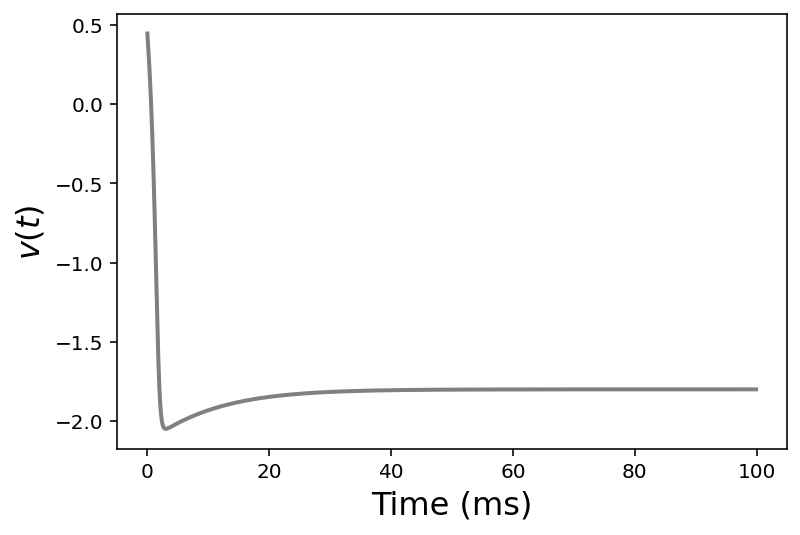

In [9]:
epsilon = 0.1
b0      = 0.
b1      = 0.2
I       = -0.5
T,dt    = 100,0.1
v0,w0   = 0.5,0.5
rv,rw   = run_fitzhugh_nagumo(v0,w0,epsilon,b0,b1,I,T,dt)
## params to try:
## I  = [-0.5,-0.4,-0.3,0.2,0.5]
## b1 = [0.2,0.5]
## also vary initial conditions

plot_pot(rv, time = np.arange(0, T, dt))
plt.xlabel('Time (ms)')
plt.ylabel(r'$v(t)$')

Text(0, 0.5, '$w(t)$')

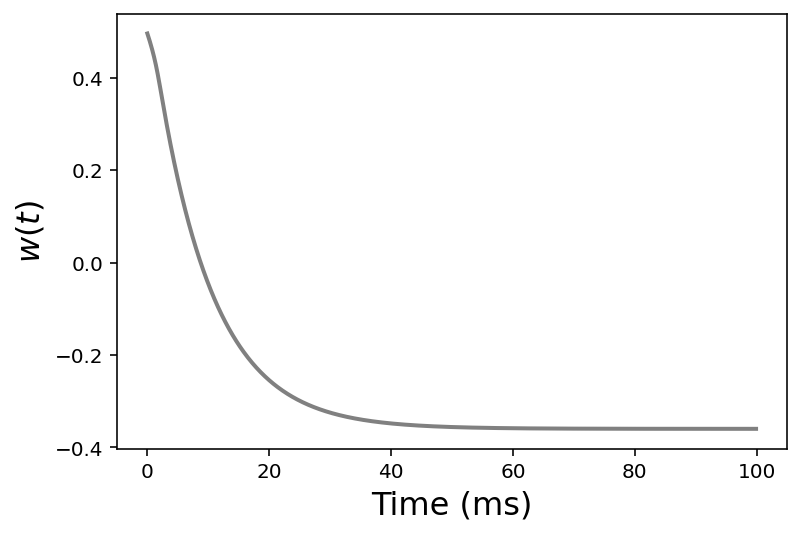

In [10]:
plot_pot(rw, time = np.arange(0, T, dt))
plt.xlabel('Time (ms)')
plt.ylabel(r'$w(t)$')

# >>> Extra: Leaky integrate-and-fire (LIF) neuron <<<

### If you managed to go through all the material so far, you can start working on the LIF model. We will work on this in more detail in the Spiking Network Tutorial

The membrane potential equation for the LIF is given by
\begin{eqnarray}
C_m\frac{dV}{dt} = -g_L(V-V_L) + I
\end{eqnarray}
$I$ is a driving current. $C_m$ is the membrane capacitance of the neuron. We also assume the membrane only has a leak conductance $g_L$, trying to bring the voltage to leak potential $V_L$. 

Dividing both sides of the equation by $g_L$ we get,
\begin{align}
\tau_m\frac{dV}{dt} = -(V-V_L) + \frac{I}{g_L}\,,\quad (1)
\end{align}
where $\tau_m=C/g_L$.

If $I$ is sufficiently strong such that $V$ reaches some threshold value $V_{th}$, $V$ will be reset to a reset potential $V_{reset}<V_{th}$, i.e.,

\begin{eqnarray}
\mathrm{if}\quad V(t)\geq V_{th}&:& V(t^+)=V_{reset}
\end{eqnarray}




To numerically solve the LIF membrane potential dynamics, we will again use Euler integration to approximate the continuous dynamics by a piecewise integration on a time-grid of stepsize $\Delta t$. 

Note once more, that in order to have a good approximation, $\Delta t$ needs to be small compared to all other time constants in the system (here $\tau_m$). The smaller $\Delta t$, the better the approximation, however, also the total computation time will be longer.

On a grid the dynamics translates to 

\begin{aligned}
\tau_m \Delta V =  \tau_m (V_{i+1}-V_i) &= \left(-(V_i-V_L) +\frac{I_{syn}}{g_L}\right)dt \\
\Leftrightarrow \qquad\qquad\qquad\quad V_{i+1} &= V_i+ \left(-(V_i-V_L) +\frac{I_{syn}}{g_L}\right)\frac{dt}{\tau_m} \quad (2)
\end{aligned}

### Simulating LIF dynamics

We will now translate the dynamics Eqn.(2) into code. We start by creating a dictionary `pm` that contains all parameters.
Then we will write several small modular functions that perform the individual operations to solve the dynamics.

We will likely need several functions to 

- initialize a dictionary that represents membrane potentials 

- initialize a dictionary that represents constant input currents **(Amplitude of constant current is generated by Gaussian distribution with mean $\mu$ and variance $\sigma^2$)**

- an update function that updates the membrane potential in each time step corresponding to the Euler integration scheme above

- a threshold handling function that resets the membrane potential in case of a crossing and registers a spike event

- a main function that combines all of the above in a sensible way to solve the LIF dynamics

In [11]:
# Some typical neuron parameters, stored in a dictionary
pm={"V_th"    : -55.,    # spike threshold [mV]
    "V_reset" : -75.,    # reset potential [mV]
    "tau_m"   : 20.,     # membrane time constant [ms]
    "g_L"     : 20.,     # leak conductance [nS]
    "V_init"  : -65,     # initial potential
    "V_L"     : -65}     # leak reversal potential

In [12]:
def init_V(n_neuron,pm):
    '''
    Intialize the array of membrane potentials 
    
    Expects:
    n_neuron : number of neurons
    pm       : parameter dictionary
    
    Returns:
    vs       : array of membrane potential values (scalars) initialized to V_init 
    '''
    
    # ADD CODE HERE
    vs = pm['V_init'] * np.ones(n_neuron)
    return vs

In [13]:
# test init_V()
vs_test = init_V(5, pm)
print(vs_test)

[-65. -65. -65. -65. -65.]


In [14]:
def init_I_syn(n_neuron,mu,sig):
    '''
    Intialize the array of direct input currents, each drawn from Gaussian distribution
    of mean mu and standard deviatiton sig
    
    Expects:
    n_neuron : number of neurons
    mu, sig  : constant driving currents with amplitudes drawn from Gaussian distribution 
               with mean mu and standard deviation sig 
               
    Returns:
    isyns    : array of driving currents
               
    '''
    
    # ADD CODE HERE
    isyns = np.random.randn(n_neuron) * sig + mu
    return isyns

In [15]:
# test init_I_syn()
isyn_test = init_I_syn(5, 10, 5)
print(isyn_test)

[12.13298981  4.77776708 -0.31843491 20.43021377  5.88550236]


In [16]:
def threshold(V,n_neuron,pm):
    '''
    Handle nonlinear threshold: 
    if potential >= V_th: reset to V_reset, indicate spike event
    
    Expects:
    V        : membrane potential [mV]
    n_neuron : number of neurons
    pm       : parameter dictionary
    
    Returns:   
    V        : updated membrane potential value [mV]
    spiking  : boolean array of length n_neuron with entries True at position i if neuron i 
               spiked in current time step, False otherwise 
    '''
    
    # ADD CODE HERE
    spiking = (V>=pm['V_th'])
    V[spiking] = pm['V_reset']
    return V, spiking
   

In [17]:
# test threshold()
V_test = np.random.rand(5)*(pm['V_th']-pm['V_reset']) * 1.5 + pm['V_reset']
print('V_test before threshold operation: ', V_test)
V_test, spiking = threshold(V_test, 5, pm)
print('V_test after threshold operation:  ', V_test)
print(spiking)

V_test before threshold operation:  [-63.32999656 -57.15609381 -52.09815899 -56.96145959 -53.37227525]
V_test after threshold operation:   [-63.32999656 -57.15609381 -75.         -56.96145959 -75.        ]
[False False  True False  True]


In [18]:
### For the update make use of Euler integration
def update(V,n_neuron,I_syn,dt,pm):
    '''
    Update dynamical state of all n_neuron membrane potentials
    (assuming all neurons have same parameters pm)
    
    Expects:
    V        : membrane potential [mV]
    n_neuron : number of neurons
    I_syn    : injected current drive [pA]
    dt       : time increment
    pm       : parameter dictionary
    
    Returns:
    V        : membrane potential
    spiking  : boolean that indicates whether neuron fired or not
    '''
    
    # ADD CODE HERE
    dVdt = ((pm['V_L']-V) + I_syn/pm['g_L'])/pm['tau_m']
    V = V + dt*dVdt
    V, spiking = threshold(V, n_neuron, pm)
    return V, spiking
    

In [19]:
# test update()
n_test = 5
isyn_test = init_I_syn(n_test, 10, 5)
V_test = np.random.rand(5)*(pm['V_th']-pm['V_reset']) * 1.2 + pm['V_reset']
print('V_test before threshold operation: ', V_test)
V_test, spiking = update(V_test, n_test, isyn_test, 0.1, pm)
print('V_test after threshold operation:  ', V_test)
print(spiking)

V_test before threshold operation:  [-74.77202524 -68.30202617 -55.71537597 -58.43704214 -57.03846676]
V_test after threshold operation:   [-74.72188726 -68.28542977 -55.76111342 -58.46598901 -57.07515913]
[False False False False False]


In [20]:
def run_LIF(n_neuron,mu,sig,T,dt,pm):
    '''
    Run LIF dynamics
    
    Expects:
    n_neuron   : number of neurons
    mu,sig     : mean and standard deviation of initial input current drives [pA]
    T          : total run time [ms]
    dt         : time increment
    pm         : parameter dictionary
    
    Returns:
    rec_spikes : dictionary of lists of spike times
    '''
    
    # ADD CODE HERE
    rec_spikes = {i:[] for i in range(n_neuron)}  # Initialize dictionary of spike trains
    t = np.arange(0, T, dt)
    V = init_V(n_neuron, pm)
    I = init_I_syn(n_neuron, mu, sig)
    for i in range(len(t)):
        V, spiking = update(V,n_neuron,I,dt,pm)
        # add spike times to spike train dictionary
        for j in np.where(spiking)[0]:
            rec_spikes[j].append(t[i] + dt)
    return rec_spikes

    

In [21]:
def plot_raster(spks:dict)->None:
    '''
    Plot raster plot
    
    Expects:
    spks      : dictionary of spike trains
    
    Returns:
    None
    '''
    for i in spks.keys():
        plt.plot(spks[i], i*np.ones(len(spks[i])), '|k')

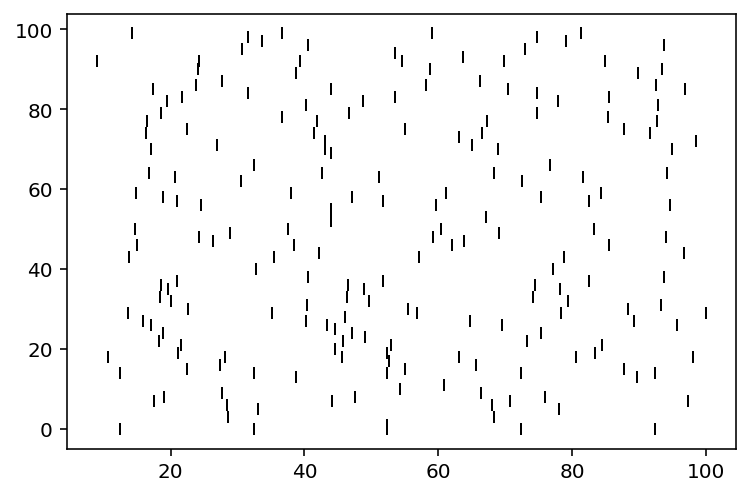

In [22]:
# test LIF_run()
# if all worked, uncomment codes below to run LIF dynamics for n_neuron uncoupled neurons

n_neuron   = 100
mu, sig    = 240,100
T,dt       = 100,0.1

rec_spikes = run_LIF(n_neuron,mu,sig,T,dt,pm)
plot_raster(rec_spikes)

### >>> EXTRA: LIF driven by Gaussian white noise and Ornstein-Uhlenbeck current <<<

So far the neurons were driven by constant currents, with amplitudes drawn randomly from a Gaussian distribution.

1) Set up a version where the input current is (approximately) Gaussian white noise $\xi(t)$ with mean $E[\xi(t)]=\mu=0$ and autocovariance $E[\xi(t)\xi(t+\tau)]=\sigma_\xi^2 \delta(\tau)$.

Hint: In order to have correct statistics of the GWN approximation on a time grid with increment $dt$ the noise amplitide $\sigma_\xi$ needs to be scaled by $1/\sqrt{dt}$. 

Make sure to test that the mean and variance of the current input your function produces has the right mean and variance.


2) Set up a version where the input current is an Ornstein-Uhlenbeck process $\eta(t)$, i.e., low-pass filtered GWN with a time constant $\tau_{\eta}$: 

$$\tau_\eta \frac{d}{dt}\eta(t) = -\eta + \sigma_\eta\sqrt{2\tau_\eta}\xi(t)$$

Make sure to test that the mean and variance of the current input your function produces has the right mean and variance.

Hint: An OUP as defined above has $E[\eta(t)]=0$ and autocovariance $[\eta(t)\eta(t+\tau)]=\sigma_\eta^2e^{-|t-\tau|/\tau_\eta}$.
